# Example 1 - Detection and quantification in Brightfield

xxx

## 1. Imports

In [ ]:
import sys
sys.path.insert(0, "../") # Adds the module to path
import deeptrack as dt

In [ ]:
import deeplay as dl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Detection in brightfield

xxx

In [ ]:
data = np.load("../data/brightfield_data.npy")
labels = np.load("../data/brightfield_labels.npy")

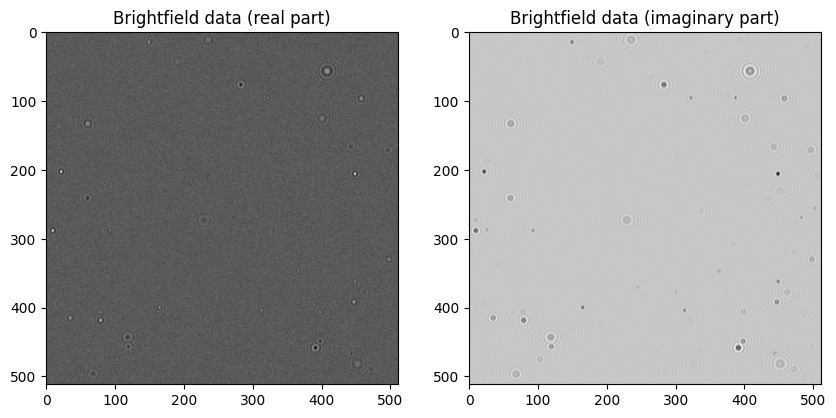

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(data[...,0], cmap="gray")
plt.title("Brightfield data (real part)")
plt.subplot(122)
plt.imshow(data[...,1], cmap="gray")
plt.title("Brightfield data (imaginary part)")
plt.show()

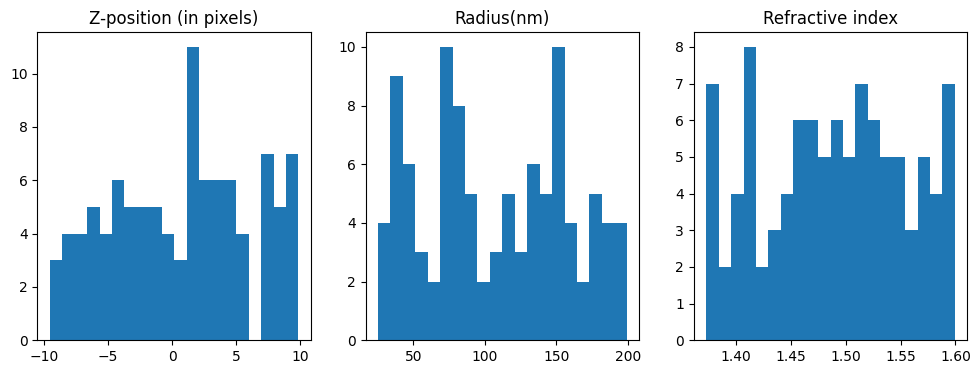

In [ ]:
#Subplot of the distribution of the labels
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(labels[:,2], bins=20)
plt.title("Z-position (in pixels)")
plt.subplot(132)
plt.hist(labels[:,3]*1e9, bins=20)
plt.title("Radius(nm)")
plt.subplot(133)
plt.hist(labels[:,4], bins=20)
plt.title("Refractive index")
plt.show()


### 2.1 Detect particles using classical method

In [ ]:
import rvt # We import the radial variance method. Cite xxx
import skimage

In [ ]:
#Apply Radial Variance Transform of image
rmin, rmax = 5, 15
det = rvt.rvt(data[...,1], rmin = rmin, rmax = rmax)

#Local max of the transformed image.
blobs = skimage.feature.peak_local_max(det, min_distance=10)
blobs = np.stack([blobs[:,0], blobs[:,1]], axis=-1)

TypeError: 'module' object is not subscriptable

In [ ]:
pauis

### 2.2 Extract regions of interest around these detections

In [ ]:
def get_rois(data, positions, padsize):
    rois = []
    for pos in positions:
        pos[0] = int(pos[0])
        pos[1] = int(pos[1])

        #Check if the roi is out of bounds
        if pos[1]-padsize < 0 or pos[1]+padsize >= data.shape[0] or pos[0]-padsize < 0 or pos[0]+padsize >= data.shape[1]:
            continue

        roi = data[pos[0]-padsize:pos[0]+padsize, pos[1]-padsize:pos[1]+padsize,:]
        rois.append(roi)
    return np.stack(rois)

In [ ]:
rois = get_rois(data, blobs, 16)
rois.shape

(210, 32, 32, 2)

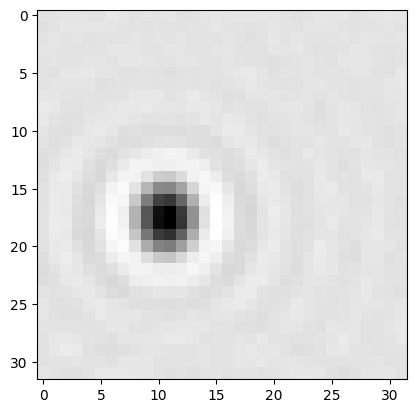

In [ ]:
plt.imshow(rois[6,...,1], cmap="gray")

### 2.1 Defining the optical system

xxx

In [ ]:
IMAGE_SIZE = 32
NA = 1.3
MAGNIFICATION = 1
WAVELENGTH = 633e-9
RESOLUTION = 1.14e-7

In [ ]:
optics = dt.Darkfield(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    #return_field=True, 
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination_angle=np.pi
)

### 2.2 Defining the particle

xxx

In [ ]:
RADIUS = 50e-9
REFRACTIVE_INDEX = 1.4
PADDING = 64

In [ ]:
particle = dt.MieSphere(
    radius=lambda: RADIUS,
    refractive_index=lambda: REFRACTIVE_INDEX,
    position=(IMAGE_SIZE / 2,) * 2,
    L=100,
)

### 2.3 Defining the dataset

We define a dataset with the particle properties imaged in the optical setup.

In [ ]:

training_data = optics(particle) 
#training_data = (imaged_particle >> dt.Real()) & (imaged_particle >> dt.Imag())
#training_data = training_data >> dt.Merge(lambda: lambda x: np.concatenate( [np.array(_x) for _x in x], axis=-1 ))

In [ ]:
training_data.store_properties()

In [ ]:
X2 = training_data.update().resolve()

In [ ]:
X2.get_property('radius')

5e-08

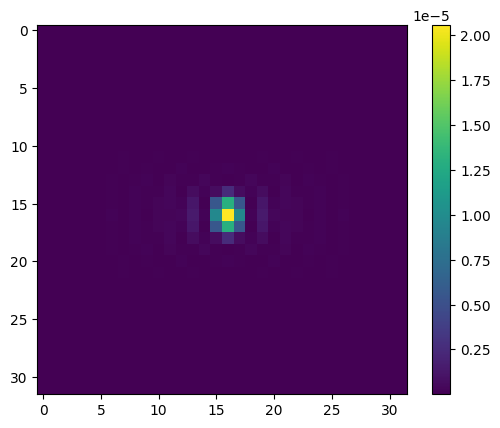

In [ ]:
plt.imshow(training_data.update().resolve())
plt.colorbar()

In [ ]:
paus

NameError: name 'paus' is not defined

In [ ]:
#For z-propagation
crop_propagation_forward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, 1e-7, RESOLUTION, WAVELENGTH)
crop_propagation_backward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, -1e-7, RESOLUTION, WAVELENGTH)

# Augmentation arguments
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randint(-2, 2),
    )

# Augmentation pipeline
group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 1e-5)
)

# Equivariance for the model
equivariance = (
     dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >>dt.models.lodestar.TranslationalEquivariance(args.translate)
    )

##################################

import numpy as np
import torch

training_pipeline = (
    dt.Value(training_data)
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, 
                                      replace=False)


In [ ]:
import deeptrack.deeplay as dl 

dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=50)
trainer.fit(lodestar, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estim

Epoch 199: 100%|██████████| 50/50 [00:01<00:00, 45.85it/s, v_num=1, train_between_image_disagreement_step=0.747, train_within_image_disagreement_step=7.73e-5, train_between_image_disagreement_epoch=0.870, train_within_image_disagreement_epoch=8.94e-5]  

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 50/50 [00:01<00:00, 45.33it/s, v_num=1, train_between_image_disagreement_step=0.747, train_within_image_disagreement_step=7.73e-5, train_between_image_disagreement_epoch=0.870, train_within_image_disagreement_epoch=8.94e-5]


AttributeError: 'numpy.ndarray' object has no attribute 'properties'

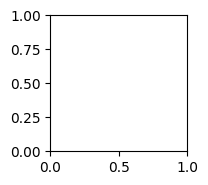

In [ ]:
val = training_data.update()()
training_set = dt.Value(lambda: np.array(val))

#3x3 grid of augmented images
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    (training_set >> group).update().plot(cmap = 'gray')
    plt.axis('off')

### 2.4 Training detection model (LodeSTAR)

In [ ]:
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    2,
    (group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)

In [ ]:

with generator:
    model = dt.models.LodeSTAR(input_shape=(None, None, 2), num_outputs=2)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    
    loss = model.fit(generator, epochs=50, steps_per_epoch=100)


Generating 201 / 200 samples before starting training
Epoch 1/50
100/100 [==============================] - 4s 17ms/step - total_loss: 2.0311 - consistency_loss: 1.2046
Epoch 2/50
100/100 [==============================] - 2s 16ms/step - total_loss: 1.9200 - consistency_loss: 1.1470
Epoch 3/50
100/100 [==============================] - 1s 12ms/step - total_loss: 1.8751 - consistency_loss: 1.0425
Epoch 4/50
100/100 [==============================] - 2s 15ms/step - total_loss: 2.2075 - consistency_loss: 0.9319
Epoch 5/50
100/100 [==============================] - 2s 17ms/step - total_loss: 1.8752 - consistency_loss: 0.9286
Epoch 6/50
100/100 [==============================] - 2s 17ms/step - total_loss: 1.5884 - consistency_loss: 0.7163
Epoch 7/50
100/100 [==============================] - 2s 17ms/step - total_loss: 1.4570 - consistency_loss: 0.5994
Epoch 8/50
100/100 [==============================] - 2s 16ms/step - total_loss: 1.3539 - consistency_loss: 0.5199
Epoch 9/50
100/100 [======

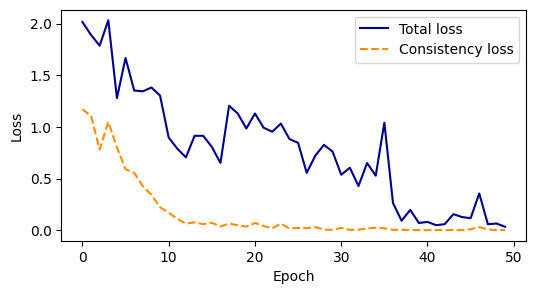

In [ ]:
plt.figure(figsize = (6,3))
plt.plot(loss.history["total_loss"], color="darkblue", label="Total loss")
plt.plot(loss.history["consistency_loss"], linestyle="--", color="darkorange", label="Consistency loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
#3x3 grid of augmented images
plt.figure(figsize=(6, 6))
for i in range(9):
    validation_data = training_data.update()()
    ground_truth_position = validation_data.get_property("position") 

    prediction = model.predict_and_pool(np.expand_dims(validation_data, axis = 0))

    plt.subplot(3, 3, i+1)
    plt.imshow(validation_data[...,0], cmap="gray")
    plt.scatter(prediction[0, 1], prediction[:, 0], s=800, linewidths=4, marker="o", facecolors="none", edgecolors="darkblue")
    plt.axis("off")

AttributeError: 

<Figure size 600x600 with 0 Axes>

## 3. Quantification in brightfield

### 3.1 Defining the optical system

xxx

In [ ]:
IMAGE_SIZE = 32
NA = 1.3
MAGNIFICATION = 1
WAVELENGTH = 633e-9
RESOLUTION = 2*1.14e-7

In [ ]:
optics = dt.Brightfield(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    return_field=True, 
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination_angle = 0
)

### 3.2 Defining the particle(s)

In [ ]:
RADIUS_RANGE = (25e-9, 200e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [ ]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 2,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
)

### 3.3 Create dataset of particles

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. The amplitude of the noise is determined by the dummy property `level`, which is explicitly shared between the two features. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [ ]:
real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: np.random.rand() * 0.02,
)

noise = real_noise >> dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.03j,
    real_sigma=real_noise.sigma
)

def func():
    def inner(image):
        image = image - 1
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func)

We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [ ]:
noisy_dataset = optics(particle >> noise) >> complex_to_float
clean_dataset = optics(particle) >> complex_to_float

dataset = noisy_dataset & clean_dataset

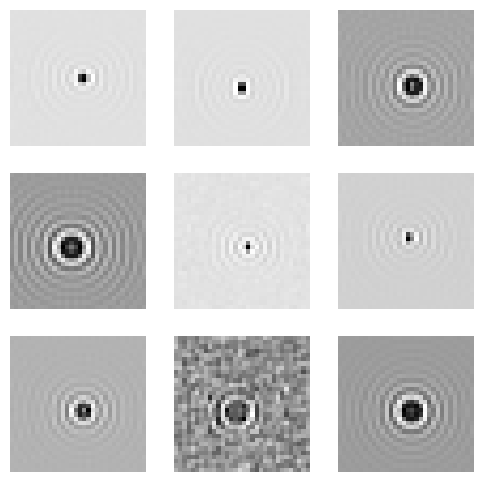

In [ ]:
#3x3 grid of augmented images
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = dataset.update().resolve()
    plt.imshow(img[0][...,1], cmap="gray")
    plt.axis('off')

### 3.4 Defining the training label

We extract the parameters we want the network to learn. This is the integrated signal.

In [ ]:
def get_label(image):
    return np.array(np.sum(image[1][...,1]))

In [ ]:
def get_polarizability(image):
    r = image[0].get_property("radius")
    n = image[0].get_property("refractive_index") - 1.33
    return np.array(4/3 * np.pi * r**3 * n)


AttributeError: 'numpy.ndarray' object has no attribute 'get_property'

In [ ]:
def batch_function(image):
    return np.array(image[0])

AttributeError: 'numpy.ndarray' object has no attribute 'get_property'

### 3.5 Defining quantification model (2DCNN)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    conv_layers_dimensions=(16, 32, 64),
    dense_layers_dimensions=(64, 64),
    steps_per_pooling=2,
    number_of_outputs=1,
    dropout=(.2, .2),
    loss="mae",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="relu")
)

model.summary()

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        304       
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 32, 32, 16)       0         
 ropout2D)                                                       
                                                             

### 3.6 Training quantification model

In [ ]:
TRAIN_MODEL = True

validation_set_size = 256
validation_set = []
validation_labels = []
for _ in range(validation_set_size):
    image = dataset.update().resolve()

    validation_set.append(image[0])
    validation_labels.append(get_label(image))

validation_set = np.array(validation_set)
validation_labels = np.array(validation_labels)

In [ ]:
model.fit(
    validation_set, 
    validation_labels,
    epochs=1,
    verbose=1
)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


8/8 [==============================] - 3s 5ms/step - loss: 0.0137


In [ ]:
if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset,
        batch_function=batch_function,
        label_function=get_label,
        min_data_size=int(1e2),
        max_data_size=int(1e3),
        batch_size=32,
        max_epochs_per_sample=33
    )

    with generator:
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            epochs=500,
        )
    
    plt.figure(figsize=(6, 3))
    plt.plot(h.history["val_loss"], label="Validation loss")
    plt.plot(h.history["loss"], label="Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")



Generating 108 / 100 samples before starting training


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
N_samples = 256
Signal = []
Pol = []
Prediction = []

for n in range(N_samples):

    image = dataset.update().resolve()
    integrated_signal = get_label(image)
    polarizability = get_polarizability(image)

    prediction = model.predict(np.expand_dims(image[0], axis=0))

    Signal.append(integrated_signal)
    Pol.append(polarizability)
    Prediction.append(prediction[0])


1/1 [==============================] - 0s 22ms/step


In [ ]:
Signal = np.array(Signal)
Pol = np.array(Pol)
Prediction = np.array(Prediction)


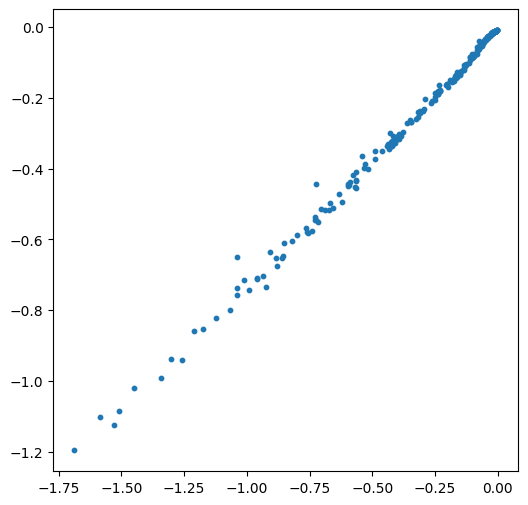

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Signal, Prediction, s=10)
plt.show()

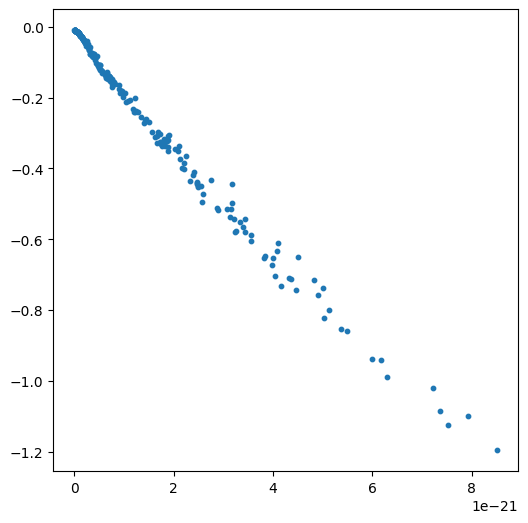

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Pol, Prediction, s=10)
plt.show()

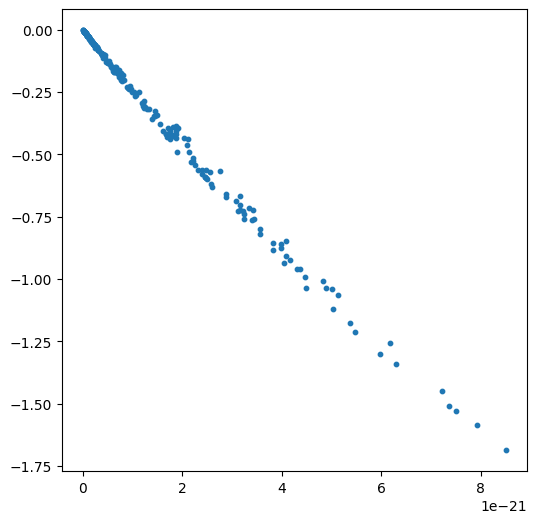

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Pol, Signal, s=10)
plt.show()

## 4. Combining detection and quantification in brightfield